# Detecção de DeepFake de áudio a partir de imagens

Instala todas as dependências necessárias

In [1]:
'''
%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install pillow
%pip install matplotlib
%pip install scikit-learn
%pip install visualkeras
%pip install pydot
%pip install graphviz
'''

'\n%pip install tensorflow\n%pip install numpy\n%pip install pandas\n%pip install pillow\n%pip install matplotlib\n%pip install scikit-learn\n%pip install visualkeras\n%pip install pydot\n%pip install graphviz\n'

In [2]:
# importa as bibliotecas

import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
from PIL import ImageFont
import matplotlib.pyplot as plt
import visualkeras as vk

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.losses import CategoricalCrossentropy
from keras.losses import categorical_crossentropy
from keras import regularizers
from keras import initializers
import time
from keras.preprocessing.image import ImageDataGenerator  # , load_img
from keras.utils import to_categorical, plot_model
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

2024-01-31 09:14:49.972116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

Num GPUs Available:  2


2024-01-31 09:14:53.933836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:14:53.934782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:14:54.165337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:14:54.166176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:14:54.166946: I tensorflow/compile

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
#TF_GPU_ALLOCATOR=cuda_malloc_async
# Começa a contar o tempo de processamento
start_time = time.time()

# Setando o endereço dos arquivos

os.getcwd()


#Path = 'F:/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Datasets/WaveFake/newData'
Path = '/mnt/f/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Datasets/ASVspoof/PA/PA'

In [5]:
#----------------------------------- Criação do Banco de Dados a Partir das Imagens -----------------------------#
os.chdir(Path)

# Real
real = os.listdir('realImgMEL')
'''for filename in real:
    if True:
        try:
            img = Image.open('realImgMEL/' + filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename) # print out the names of corrupt files
            real.remove(filename)
'''
try:
    real.remove("desktop.ini")
except:
    print("não existe desktop.ini")

# Fake
fake = os.listdir('fakeImgMEL')
'''for filename in fake:
    if True:
        try:
            img = Image.open('fakeImgMEL/' + filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename) # print out the names of corrupt files
            fake.remove(filename)
'''
try:
    real.remove("desktop.ini")
except:
    print("não existe desktop.ini")

auxReal = []
auxDir = []
for i in real:
    auxReal.append(0)
    auxDir.append("realImgMEL/" + i)
real = pd.DataFrame({'filename': auxDir, 'category': auxReal})

auxFake = []
auxDir = []
for i in fake:
    auxFake.append(1)
    auxDir.append("fakeImgMEL/" + i)
fake = pd.DataFrame({'filename': auxDir, 'category': auxFake})

não existe desktop.ini
não existe desktop.ini


<Axes: xlabel='category'>

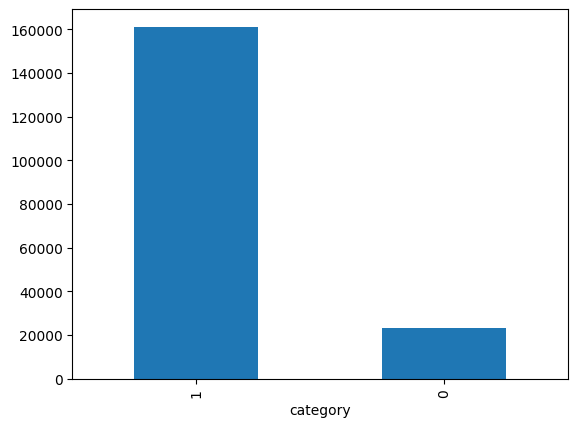

In [6]:
TotalImgs = [real, fake]
TotalImgs = pd.concat(TotalImgs)
TotalImgs = TotalImgs.sample(frac=1, random_state=42)

TotalImgs['category'].value_counts().plot.bar()

In [7]:
tr, ts = train_test_split(TotalImgs, test_size=0.3, random_state=42)
ts, vl = train_test_split(ts, test_size= 0.5, random_state=42)

'''
tr = [realTR, fakeTR]
tr = pd.concat(tr)
ts = [realTS, fakeTS]
ts = pd.concat(ts)
vl = [realVL, fakeVL]
vl = pd.concat(vl)
'''

'\ntr = [realTR, fakeTR]\ntr = pd.concat(tr)\nts = [realTS, fakeTS]\nts = pd.concat(ts)\nvl = [realVL, fakeVL]\nvl = pd.concat(vl)\n'

<Axes: xlabel='category'>

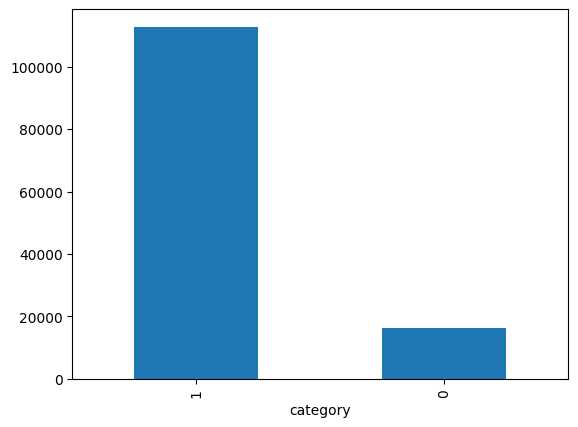

In [8]:
tr['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

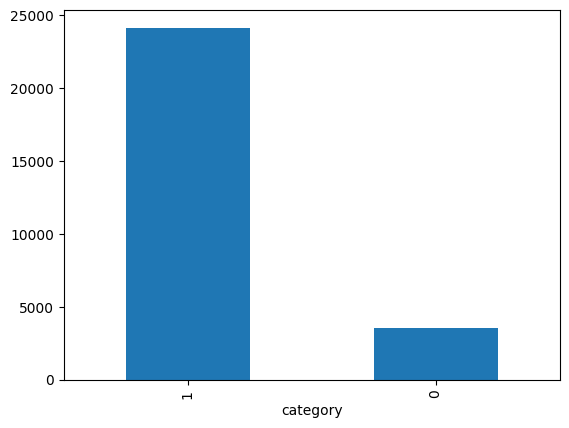

In [9]:
ts['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

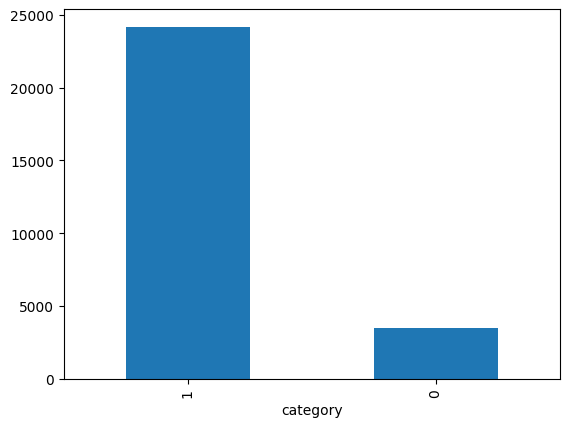

In [10]:
vl['category'].value_counts().plot.bar()

In [11]:
# ----------------------------------- Modelagem da CNN -----------------------------#

# Define Constants
FAST_RUN = True
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [12]:
# Gerando o modelo
model = Sequential()

model.add(Conv2D(8, (5, 5), activation='relu', input_shape=(
    IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

'''
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
'''
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(
    5000,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    activation='relu',
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(
    2,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    activation='softmax',
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))

2024-01-31 09:28:24.489647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:28:24.490430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:28:24.491177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:28:24.492034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:81:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 09:28:24.492753: I tensorflow/compile

In [13]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="adam"
)
'''
opt = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.2,
    nesterov=False,
    name="SGD"
)
'''

model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 batch_normalization (Batch  (None, 252, 252, 8)       32        
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 126, 126, 8)       0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 126, 126, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       72        
                                                                 
 batch_normalization_1 (Bat  (None, 126, 126, 8)       3

 dropout_2 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        1056      
                                                                 
 batch_normalization_5 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 average_pooling2d_3 (Avera  (None, 14, 14, 64)        0         
 gePooling2D)                                                    
                                                                 
 dropout_3

In [14]:
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after one steps
fname = "weights-best.hdf5"
#fname = "weights-{epoch:02d}-{val_categorical_accuracy:.4f}.hdf5"
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after one steps
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='categorical_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    fname,
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Saved callbacks parameters
#callbacks = [earlystop, learning_rate_reduction,model_checkpoint]
callbacks = [learning_rate_reduction,model_checkpoint]

In [15]:
# Replace output label data
tr["category"] = tr["category"].replace({0: 'Real', 1: 'Fake'})
ts["category"] = ts["category"].replace({0: 'Real', 1: 'Fake'})
vl["category"] = vl["category"].replace({0: 'Real', 1: 'Fake'})

In [16]:
total_train = tr.shape[0]
total_validate = vl.shape[0]
total_test = ts.shape[0]
batch_size = 32

In [17]:
os.chdir(Path)
trn = tr.sample(frac=1, random_state = 42)
add = "training"

# generic image data generator
train_datagen = ImageDataGenerator(
    #rotation_range=90,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=False,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    #validation_split=0.7
)

# Train image data generator
# Create new train folder directory which should have both the images real and fake combined.
train_generator = train_datagen.flow_from_dataframe(
    trn,
    Path,
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    #subset='training',
    batch_size=batch_size,
    shuffle= True
)

Found 129210 validated image filenames belonging to 2 classes.


In [18]:
'''
validation_generator = train_datagen.flow_from_dataframe(
    trn,
    add,
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size,
    shuffle=True
)
'''
#os.chdir(Path)
val = vl.sample(frac=1, random_state = 42)
add = "validation"
# Validation image data generator
validation_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val,
    Path,
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 27689 validated image filenames belonging to 2 classes.


In [19]:
model.save('model-Mel.h5',save_format='h5')

/home/lucas/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
#PathImg = 'D:/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Imagens'
PathImg = '/mnt/d/Google Drive/EnsinoAprendizagem/UFC/Mestrado/Dissertação/Imagens'

In [21]:
'''
#input_L
plot_model(
    model,
    to_file = PathImg + '/modelIn.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range=["batch_normalization", "conv2d_1"],
    show_layer_activations=True
    )'''

'\n#input_L\nplot_model(\n    model,\n    to_file = PathImg + \'/modelIn.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=False,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range=["batch_normalization", "conv2d_1"],\n    show_layer_activations=True\n    )'

In [22]:
'''
# conv_L1
plot_model(
    model,
    to_file = PathImg + '/modelC1.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range=["batch_normalization_1", "conv2d_3"],
    show_layer_activations=True
    )'''


'\n# conv_L1\nplot_model(\n    model,\n    to_file = PathImg + \'/modelC1.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=False,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range=["batch_normalization_1", "conv2d_3"],\n    show_layer_activations=True\n    )'

In [23]:
'''
# conv_L2
plot_model(
    model,
    to_file = PathImg + '/modelC2.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range=["batch_normalization_3", "conv2d_5"],
    show_layer_activations=True
    )'''

'\n# conv_L2\nplot_model(\n    model,\n    to_file = PathImg + \'/modelC2.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=False,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range=["batch_normalization_3", "conv2d_5"],\n    show_layer_activations=True\n    )'

In [24]:
'''
# conv_L3
plot_model(
    model,
    to_file = PathImg + '/modelC3.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range=["batch_normalization_5", "conv2d_7"],
    show_layer_activations=True
    )'''

'\n# conv_L3\nplot_model(\n    model,\n    to_file = PathImg + \'/modelC3.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=False,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range=["batch_normalization_5", "conv2d_7"],\n    show_layer_activations=True\n    )'

In [25]:
'''
# conv_L4
plot_model(
    model,
    to_file = PathImg + '/modelC4.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range=["batch_normalization_7", "flatten"],
    show_layer_activations=True
    )'''

'\n# conv_L4\nplot_model(\n    model,\n    to_file = PathImg + \'/modelC4.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=False,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range=["batch_normalization_7", "flatten"],\n    show_layer_activations=True\n    )'

In [26]:
'''
# output_L
plot_model(
    model,
    to_file = PathImg + '/modelOut.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=90,
    layer_range = None,#["dropout_5", "dense_1"], # Not working well
    show_layer_activations=True
    )'''

'\n# output_L\nplot_model(\n    model,\n    to_file = PathImg + \'/modelOut.png\',\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=True,\n    rankdir="LR",\n    expand_nested=True,\n    dpi=90,\n    layer_range = None,#["dropout_5", "dense_1"], # Not working well\n    show_layer_activations=True\n    )'

In [27]:
'''#%pip install visualkeras
import visualkeras as vk
#font = ImageFont.truetype("times.ttf", 22)
vk.layered_view(
    model,
    legend=True,
    one_dim_orientation='y',
    max_xy=800,
    #font=font,
    draw_volume=True,
    scale_xy=4
    )'''

'#%pip install visualkeras\nimport visualkeras as vk\n#font = ImageFont.truetype("times.ttf", 22)\nvk.layered_view(\n    model,\n    legend=True,\n    one_dim_orientation=\'y\',\n    max_xy=800,\n    #font=font,\n    draw_volume=True,\n    scale_xy=4\n    )'

In [28]:
model.load_weights(fname)
model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [29]:
#tf.tf_reset_default_graph()

# Treinamento e validação da rede
Epochs = 20 if FAST_RUN else 100
history = model.fit(
    #tf.constant(trn['filename']),
    #tf.constant(trn['category']),
    train_generator,
    epochs=Epochs,
    #shuffle=True,
    #batch_size=None,
    #validation_split=0.2,
    validation_data=validation_generator,#train_generator,
    validation_steps=total_validate//batch_size,#total_train//batch_size,
    steps_per_epoch=total_train//batch_size,#100,
    # [Originally steps per epoch should be total_train//batch_size but for now lets try with 50]
    callbacks=callbacks
)

Epoch 1/20


2024-01-31 09:47:54.818074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-31 09:47:59.842444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-01-31 09:48:00.670642: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 09:48:01.259523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-31 09:48:01.512504: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f26ec023a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 09:48:01.512588: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor devi

4036/4037 [============================>.] - ETA: 2s - loss: 0.2023 - categorical_accuracy: 0.9446
Epoch 1: val_categorical_accuracy improved from -inf to 0.91503, saving model to weights-best.hdf5
4037/4037 [==============================] - 12079s 3s/step - loss: 0.2023 - categorical_accuracy: 0.9446 - val_loss: 0.2657 - val_categorical_accuracy: 0.9150 - lr: 0.0010
Epoch 2/20
4036/4037 [============================>.] - ETA: 0s - loss: 0.1929 - categorical_accuracy: 0.9459
Epoch 2: val_categorical_accuracy did not improve from 0.91503
4037/4037 [==============================] - 4923s 1s/step - loss: 0.1929 - categorical_accuracy: 0.9460 - val_loss: 0.3514 - val_categorical_accuracy: 0.9084 - lr: 0.0010
Epoch 3/20
4036/4037 [============================>.] - ETA: 1s - loss: 0.1950 - categorical_accuracy: 0.9463
Epoch 3: val_categorical_accuracy improved from 0.91503 to 0.93826, saving model to weights-best.hdf5
4037/4037 [==============================] - 5882s 1s/step - loss: 0.195

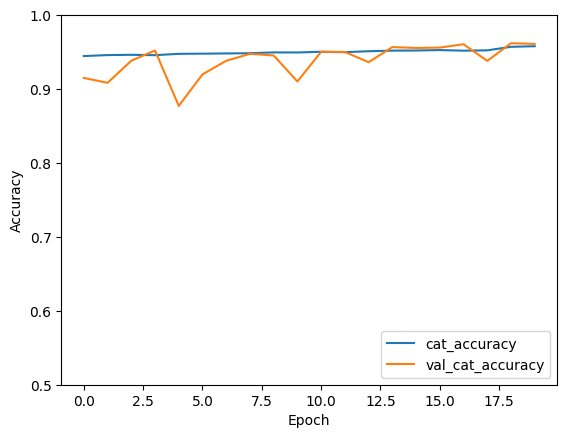

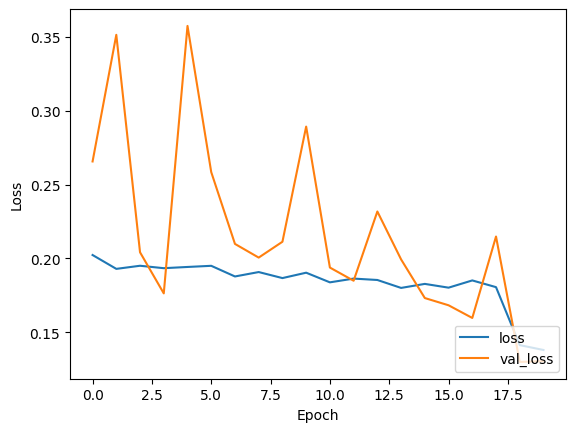

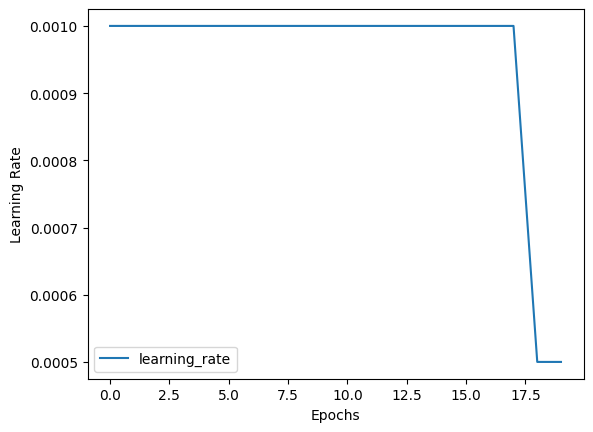

In [30]:
# ----------------------------------- Teste da rede -----------------------------#

plt.figure()
plt.plot(history.history['categorical_accuracy'], label='cat_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_cat_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['lr'], label='learning_rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

Carregar o modelo com melhor resultado de acurácia

In [31]:
model.load_weights(fname)
model.compile(
    loss='categorical_crossentropy',
    optimizer= opt,
    metrics=['categorical_accuracy']
)

In [32]:
os.chdir(Path)
test = ts.sample(frac = 1, random_state = 42)
add = "testing"
# Used above created test dataset for test image data generator
test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test,
    Path,
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 27688 validated image filenames belonging to 2 classes.


In [33]:
predict = model.predict(
    test_generator,
    steps=np.ceil(total_test/batch_size),
    verbose=1)

#test['Pred_category'] = tf.greater(predict, .5)
test['Pred_category'] = np.argmax(predict, axis=1)

label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test['Pred_category'] = test['Pred_category'].replace(label_map)

866/866 [==============================] - 540s 623ms/step


<Figure size 640x480 with 0 Axes>

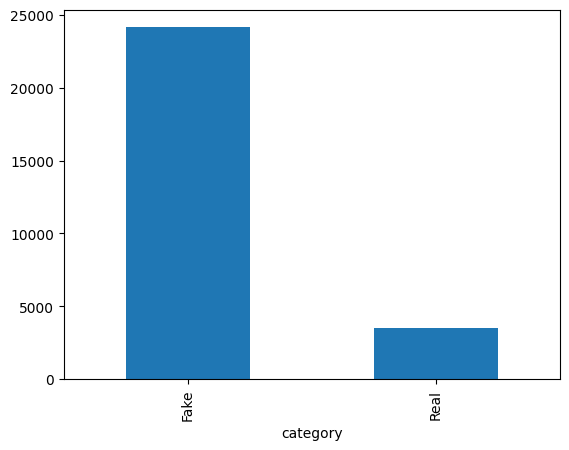

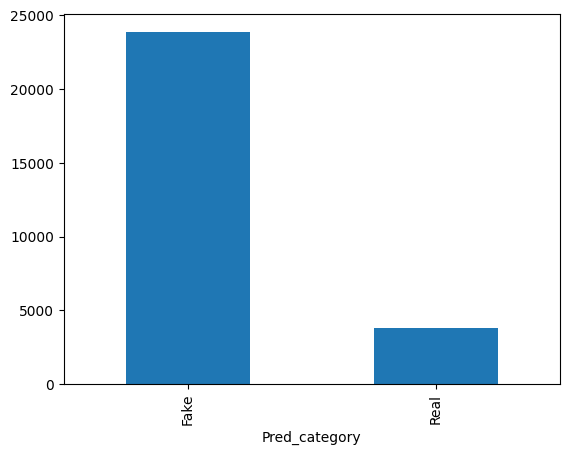

In [34]:
plt.figure()
plt.subplots(1, 1)
test['category'].value_counts().plot.bar()
plt.subplots(1, 1)
test['Pred_category'].value_counts().plot.bar()
plt.show()

In [35]:
test['category'].value_counts()

category
Fake    24145
Real     3543
Name: count, dtype: int64

In [36]:
test['Pred_category'].value_counts()

Pred_category
Fake    23863
Real     3825
Name: count, dtype: int64

In [37]:
print('Prediction Accuracy =',metrics.accuracy_score(test['category'], test['Pred_category']))

Prediction Accuracy = 0.9607049985553309


In [38]:
scores = model.evaluate(test_generator, steps=np.ceil(
    total_test/batch_size), verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

866/866 [==============================] - 416s 479ms/step - loss: 0.1313 - categorical_accuracy: 0.9607
categorical_accuracy: 96.07%


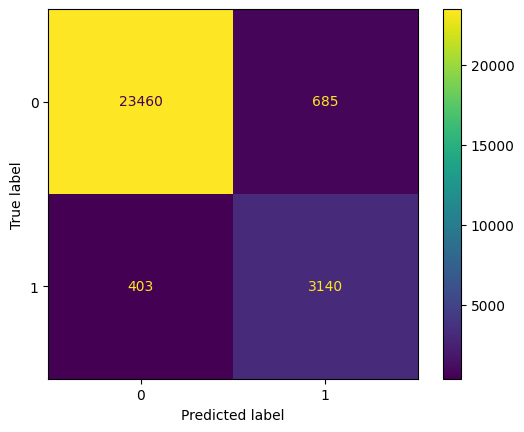

In [39]:
conf = confusion_matrix(y_pred=test['Pred_category'],y_true=test['category'])
disp = ConfusionMatrixDisplay(conf)
disp.plot()
plt.show()

In [40]:
# Tempo total de processamento
print("--- %s seconds ---" % (time.time() - start_time))

--- 69885.92206716537 seconds ---
